#### Use NLP to Prioritize the Most Important Product Failings to Fix
Product Reviews contain valuable information about which product flaws cause negative reviews. Natural Language Processing of these reviews reveals patterns based on thousands of reviews and results in a prioritized list. Product managers can therefore spend their scarce resources fixing the most impactful problems.

For Data Scientists, here’s the approach taken:
* Model built using Python 3 and scikit-learn, NLTK packages
* Load and merge the two product data sets for the Electronic Insect Killer product
* Keep only the ‘review’, ‘summary’ and ‘rating’ columns
* Preprocess the text 
    * Combine the review and summary text fields
    * Make text lower case, take out common words (like ‘the’), take out words with 3 or fewer characters, ignore special characters, tokenize the words
* Use TFIDF vectorizer to make the words processable by machine learning algorithms 
* Look at groups of 2, 3 and 4 consecutive words (n-grams); not single words
* Apply Random Forest algorithm to predict if the review is a Positive Review (4 or 5 stars) or a Negative Review (1, 2 or 3 stars)
    * Train model on 75% of the data, have model make predictions on 25% of the data 
    * Model predicted pretty well; AUC = 0.86, overall accuracy = 0.82.
    * Recall of predicting a Positive Review was 0.99 but Recall of predicting a Negative Review was only 0.27.  
* Look at the 200 most influential word groups that are predictive of a positive or negative review. 
    * Manually pick out the groups of words that look like they deal with product flaws. For this article, I focused on the bulb because it showed up 4 times within the top 26 word-combinations.
    * Manually scan the subset of reviews that deal with the bulb to understand more about the context. 
* Put together cross-functional action plan to address the product attribute that makes customers so unhappy. 


#### Citation and Data Dictionary
Please cite the following paper if you use the data in any way:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019
pdf

Website:  https://nijianmo.github.io/amazon/index.html#subsets

In the Review Data:

* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* vote - helpful votes of the review
* style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
* reviewText - text of the review
* overall - rating of the product
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)
* image - images that users post after they have received the product

In the Meta Data:


* asin - ID of the product, e.g. 0000031852
* title - name of the product
* feature - bullet-point format features of the product
* description - description of the product
* price - price in US dollars (at time of crawl)
* imageURL - url of the product image
* imageURL - url of the high resolution product image
* related - related products (also bought, also viewed, bought together, buy after viewing)
* salesRank - sales rank information
* brand - brand name
* categories - list of categories the product belongs to
* tech1 - the first technical detail table of the product
* tech2 - the second technical detail table of the product
* similar - similar product table

In [59]:
# pwd

In [60]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import re

# Enable libraries to print in-line
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

#Import additional sklearn algorithms and performance measurement libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score


# Import Machine Learning, Preprocessing and Metrics Libraries
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression        # Import Logistic Regression
from sklearn.model_selection import train_test_split       # Import Train-Test Splitter
from sklearn.model_selection import RandomizedSearchCV     # Random tuner
import time
# from sklearn.model_selection import GridSearchCV           # Tuning Hyper pararmeters with grid search 
import xgboost as xgb
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [61]:

from tqdm import tqdm
import time
  
  
for i in tqdm (range (101), 
               desc="Loading…", 
               ascii=False, ncols=75):
    time.sleep(0.01)
      
print("Complete.")
import gzip
import json

Loading…: 100%|██████████████████████████| 101/101 [00:01<00:00, 63.87it/s]

Complete.


In [62]:
{
   "codeCellConfig": {
      "lineWrap": "wordWrapColumn",
      "wordWrapColumn": 80
   }
}

{'codeCellConfig': {'lineWrap': 'wordWrapColumn', 'wordWrapColumn': 80}}

### LOAD DATA

In [63]:

# Code to load data from .json.gz files.  Do this the first time to create the csv files, then comment out.
# No need to repeat this long process.  Instead, load the .csv files with initial cleaned data-  see next cell.

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


df_review = getDF('Patio_Lawn_and_Garden.json.gz')
df_meta = getDF('meta_Patio_Lawn_and_Garden.json.gz')

#  Rename overall column to 'rating', drop the style column for now because it contains a dictionary
#  Drop duplicates of asin in df_meta

df_review.rename(columns = {'overall':'rating'}, inplace = True)
df_review= df_review.drop(['style'], axis=1)

df_meta = df_meta.drop_duplicates(subset = ['asin'])

# Do some data cleanup, replace NAs with 'none'
df_review.summary = df_review.summary.fillna('none')
df_review.reviewText = df_review.reviewText.fillna('none')
#  df_review.rating = df_review.rating.fillna('none')    #Turns out there are no NAs in rating column- I checked

# Do some data cleanup, replace NAs with 'none'
df_review.summary = df_review.summary.fillna('none')
df_review.reviewText = df_review.reviewText.fillna('none')
#  df_review.rating = df_review.rating.fillna('none')    #Turns out there are no NAs in rating column- I checked:

print("Sum of na's, by column: ", df_review.isnull().sum(axis = 0))
print("Sum of all na's in df: ", df_review.isna().sum().sum())

# To make life easier, save these huge files into csv's so they can be called up more quickly
# saving the dataframe
df_review.to_csv('Reviews_Dataset.csv')   
df_meta.to_csv('Meta_Dataset.csv')

'\n# Original Loading of data from .json.gz files.  Do this is csv files are gone or corrupted\n# No need to repeat this long process.  Instead, load the .csv files with initial cleaned data-  see next cell.\n\ndef parse(path):\n  g = gzip.open(path, \'rb\')\n  for l in g:\n    yield json.loads(l)\n\ndef getDF(path):\n  i = 0\n  df = {}\n  for d in parse(path):\n    df[i] = d\n    i += 1\n  return pd.DataFrame.from_dict(df, orient=\'index\')\n\n\ndf_review = getDF(\'Patio_Lawn_and_Garden.json.gz\')\ndf_meta = getDF(\'meta_Patio_Lawn_and_Garden.json.gz\')\n\n#  Rename overall column to \'rating\', drop the style column for now because it contains a dictionary\n#  Drop duplicates of asin in df_meta\n\ndf_review.rename(columns = {\'overall\':\'rating\'}, inplace = True)\ndf_review= df_review.drop([\'style\'], axis=1)\n\ndf_meta = df_meta.drop_duplicates(subset = [\'asin\'])\n\n# Do some data cleanup, replace NAs with \'none\'\ndf_review.summary = df_review.summary.fillna(\'none\')\ndf_rev

#### Define Functions that Load, Merge and Preprocess the Review Data

In [64]:
# Read review data and meta data
# Defining Functions  https://www.oreilly.com/library/view/head-first-python/9781491919521/ch04.html 

def load_merge(review_file, meta_file, asin):
    
    '''This function loads the review file and the meta file, then after filtering for one asin product number
    for both files, produces a merged file for that asin product number'''
    
    df_meta= pd.read_csv(meta_file)   # engine = 'python' doesn't work for some reason
    df_review = pd.read_csv(review_file)
    Prod_Review = df_review[df_review['asin']== asin]
    Prod_Meta = df_meta[df_meta['asin']== asin]
    Prod_merge = Prod_Review.merge(Prod_Meta, on='asin', how='inner')
    return Prod_merge
   

In [65]:
# Let's create review_words to combine the reviewText and summary columns

# PREPROCESSING OF TEXT:  
# For vectorizer to work, there can't be NaN's.  Fill with 'none'
# Make all letters lower case, leave only a-z, 0-9, take out stop words and words <3 characters

# disable chained assignments
pd.options.mode.chained_assignment = None 

def preprocess(df, stop_words):
    df.summary = df.summary.fillna('none')
    df.reviewText = df.reviewText.fillna('none')
    df.rating = df.rating.fillna('none')
    # df.Verified_Review = df.Verified_Review.fillna(0)
    df["review_words"] = df["reviewText"]   + " " + df["summary"]    #   +" "+ df["category"]  ADD LATER?
    df['review_words'] = df['review_words'].str.lower()
    df['review_words'] = df['review_words'].str.replace("[^a-zA-Z+%0-9]", " ")
    df["review_words"] = df["review_words"].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    df['review_words'] = df['review_words'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))
    return df


# NOTE !!!!!!    Do not do this twice or more- it repeats the concatenation.




In [66]:
# Take a subset of data, specifically one product   B00004R9VV   Insect Killer
# For this product there should be 8166 rows and 31 columns in the Prod_merge output

Prod_merge = load_merge("Meta_Dataset.csv", "Reviews_Dataset.csv"   , 'B00004R9VV')    # OR  B00004R9VV

C:\Users\lucin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\lucin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [67]:
Prod_merge.head(3)

,Unnamed: 0_x,category,tech1,description,fit,title,also_buy,tech2,brand,feature,...,rating,vote,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,unixReviewTime,image
0,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,2.0,7,False,"06 3, 2002",A1JYVOX5AX65N9,Julia,Poor product. It will kill insects after it is...,Flowtron Insect Killer,1023062400,NaN
1,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,5.0,20,False,"06 1, 2002",A2J2SZC2H8N0WZ,Ross,This bug popper really does a great job. You d...,Works Great!,1022889600,NaN
2,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,1.0,33,True,"04 27, 2002",ANIATM2KZ3OP7,Hugh D. Murray,It seemed to be doing the job. Then after less...,Already Broke!,1019865600,NaN


In [68]:
# Check for nulls in each column

df = Prod_merge

df.isnull().sum(axis = 0)


Unnamed: 0_x          0
category              0
tech1              8166
description           0
fit                8166
title                 0
also_buy              0
tech2              8166
brand                 0
feature               0
rank                  0
also_view             0
main_cat              0
similar_item          0
date               8166
price                 0
asin                  0
imageURL              0
imageURLHighRes       0
details               0
Unnamed: 0_y          0
rating                0
vote               7291
verified              0
reviewTime            0
reviewerID            0
reviewerName          0
reviewText            0
summary               0
unixReviewTime        0
image              8050
dtype: int64

In [69]:
'''# Take a subset of data, specifically one product   B00004R9VV  Insect Killer

Prod_Review = df_review[df_review['asin']=="B00004R9VV"]
Prod_Meta = df_meta[df_meta['asin']=='B00004R9VV']
Prod_Review.shape
Prod_Meta.shape        # Shape is 1,20 because there's one product with this 'asin'
'''

'# Take a subset of data, specifically one product   B00004R9VV  Insect Killer\n\nProd_Review = df_review[df_review[\'asin\']=="B00004R9VV"]\nProd_Meta = df_meta[df_meta[\'asin\']==\'B00004R9VV\']\nProd_Review.shape\nProd_Meta.shape        # Shape is 1,20 because there\'s one product with this \'asin\'\n'

###  Initial EDA

In [70]:
'''
# DO THIS ONLY FOR EDA, NOT MAIN FLOW OF ANALYSIS
# Get value counts to see the top 10 value counts in each column
df = Prod_merge

for(columnName, columnData) in df.iteritems():
    print('Column Name: ', columnName)
    print()
    print('Column Value      Counts')
    print(columnData.value_counts().head(n = 20))
    print()
    print()'''

"\n# DO THIS ONLY FOR EDA, NOT MAIN FLOW OF ANALYSIS\n# Get value counts to see the top 10 value counts in each column\ndf = Prod_merge\n\nfor(columnName, columnData) in df.iteritems():\n    print('Column Name: ', columnName)\n    print()\n    print('Column Value      Counts')\n    print(columnData.value_counts().head(n = 20))\n    print()\n    print()"

In [71]:
# Choose the features (column names) that we want to work with:  rating, asin (product number), reviewText and summary

list(Prod_merge)              # to see all the column names
feat1 = ['rating',
 'asin',
 'reviewText',
 'summary']

feat1

# Create a df that includes the one hundred products with the most ratings = 1.  This will generate at dataset that has a 
# a variety of flaws that we can build recommendations upon.

Prod_merge = Prod_merge[feat1]
Prod_merge.shape
Prod_merge.head(3)

['Unnamed: 0_x',
 'category',
 'tech1',
 'description',
 'fit',
 'title',
 'also_buy',
 'tech2',
 'brand',
 'feature',
 'rank',
 'also_view',
 'main_cat',
 'similar_item',
 'date',
 'price',
 'asin',
 'imageURL',
 'imageURLHighRes',
 'details',
 'Unnamed: 0_y',
 'rating',
 'vote',
 'verified',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'reviewText',
 'summary',
 'unixReviewTime',
 'image']

['rating', 'asin', 'reviewText', 'summary']

(8166, 4)

,rating,asin,reviewText,summary
0,2.0,B00004R9VV,Poor product. It will kill insects after it is...,Flowtron Insect Killer
1,5.0,B00004R9VV,This bug popper really does a great job. You d...,Works Great!
2,1.0,B00004R9VV,It seemed to be doing the job. Then after less...,Already Broke!


In [72]:
# For Product B00004R9VV  (Flowtron Bug Killer), average rating is 4.11 stars

Prod_merge.rating.describe()
Prod_merge.dtypes

count    8166.000000
mean        4.112907
std         1.343871
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

rating        float64
asin           object
reviewText     object
summary        object
dtype: object

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='rating', ylabel='count'>

Text(0.5, 1.0, 'Electronic Insect Killer Star Review Counts  \n')

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, 'Count of Star Ratings')

Text(0.5, 0, 'Star Rating')

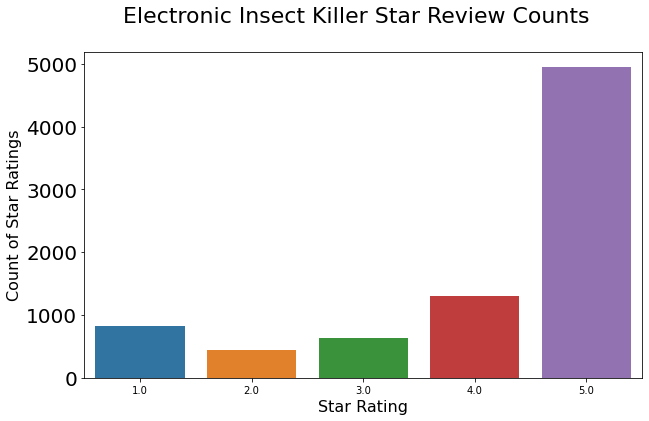

In [73]:
 # plot grouped bar chart
    
plt.figure(figsize=(10,6)) 
sns.countplot(x='rating', data=df)
plt.title('Electronic Insect Killer Star Review Counts  \n', fontsize = 22)
# plt.xticks(rotation = 25, horizontalalignment='right', fontsize  = 14)
plt.yticks(fontsize = 20)
plt.ylabel('Count of Star Ratings', fontsize=16)
plt.xlabel('Star Rating', fontsize=16)

### Do NLP Treatment on Electronic Insect Killer

This is an interesting product because almost 2000 reviews are Negative (1, 2 and 3-star reviews). What are the product flaws that are most prevalent in these negative reviews?

Do NLP Treatment on Electronic Insect Killer

* B00004R9VV     832   Electronic Insect Killer    --              $70, interesting


###  Preprocess Text Data

In [74]:
Prod_merge.reviewText.head(1)

0    Poor product. It will kill insects after it is...
Name: reviewText, dtype: object

In [75]:
'''
Define stop_words and use the pre-process function (defined above) to pre-process the review_words in Prod_merge
Preprocess the text:
    Combine the review and summary text fields
    Make text lower case, take out common words (like ‘the’), take out words with 3 or fewer characters, ignore special characters, tokenize the words
'''
stop_words = stopwords.words('english')
df = preprocess(Prod_merge, stop_words)

# NOTE !!!!!!    Do not do this twice or more- it repeats the concatenation.

'\nDefine stop_words and use the pre-process function (defined above) to pre-process the review_words in Prod_merge\nPreprocess the text:\n    Combine the review and summary text fields\n    Make text lower case, take out common words (like ‘the’), take out words with 3 or fewer characters, ignore special characters, tokenize the words\n'

<ipython-input-65-ac493a8addc8>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_words'] = df['review_words'].str.replace("[^a-zA-Z+%0-9]", " ")


In [76]:
# Let's count the most common terms in the 'name' column   ADAPTED FROM CAPSTONE AND MEL
df.review_words.str.split(expand=True).stack().value_counts()

bugs        4030
works       3234
great       2889
one         2670
bug         2279
            ... 
altough        1
x12            1
atracted       1
alarmed        1
forming        1
Length: 10683, dtype: int64

### Use TFIDF to Vectorize, Use Random Forest to Predict

In [77]:
# Use the load_merge function to load the review and meta datasets, filter to one product, and merge the data for that product

# Take a subset of data, specifically one product   B00004R9VV  Flowtron Insect Killer
# For this product there should be 8166 rows and 31 columns in the Prod_merge output

Prod_merge = load_merge("Meta_Dataset.csv", "Reviews_Dataset.csv"   , 'B00004R9VV')    # OR  B00004R9VV
Prod_merge.head(3)

# Check for nulls in each column

df = Prod_merge
df.isnull().sum(axis = 0)


C:\Users\lucin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\lucin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,Unnamed: 0_x,category,tech1,description,fit,title,also_buy,tech2,brand,feature,...,rating,vote,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,unixReviewTime,image
0,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,2.0,7,False,"06 3, 2002",A1JYVOX5AX65N9,Julia,Poor product. It will kill insects after it is...,Flowtron Insect Killer,1023062400,NaN
1,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,5.0,20,False,"06 1, 2002",A2J2SZC2H8N0WZ,Ross,This bug popper really does a great job. You d...,Works Great!,1022889600,NaN
2,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,1.0,33,True,"04 27, 2002",ANIATM2KZ3OP7,Hugh D. Murray,It seemed to be doing the job. Then after less...,Already Broke!,1019865600,NaN


Unnamed: 0_x          0
category              0
tech1              8166
description           0
fit                8166
title                 0
also_buy              0
tech2              8166
brand                 0
feature               0
rank                  0
also_view             0
main_cat              0
similar_item          0
date               8166
price                 0
asin                  0
imageURL              0
imageURLHighRes       0
details               0
Unnamed: 0_y          0
rating                0
vote               7291
verified              0
reviewTime            0
reviewerID            0
reviewerName          0
reviewText            0
summary               0
unixReviewTime        0
image              8050
dtype: int64

In [78]:
# Choose the features (column names) that we want to work with

# list(Prod_merge)
feat1 = ['rating',
 'asin',
 'reviewText',
 'summary']

feat1

# Create a df that includes the one hundred products with the most ratings = 1.  This will generate at dataset that has a 
# a variety of flaws that we can build recommendations upon.

Prod_merge = Prod_merge[feat1]
Prod_merge.shape
# Prod_merge.head(3)


['rating', 'asin', 'reviewText', 'summary']

(8166, 4)

In [79]:
# Define stop_words and use the pre-process function to pre-process the review_words in Prod_merge

stop_words = stopwords.words('english')
df = preprocess(Prod_merge, stop_words)

# NOTE !!!!!!    Do not do this twice or more- it repeats the concatenation.

<ipython-input-65-ac493a8addc8>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_words'] = df['review_words'].str.replace("[^a-zA-Z+%0-9]", " ")


In [80]:
# Let's count the most common terms in the 'name' column   ADAPTED FROM CAPSTONE AND MEL
df.review_words.str.split(expand=True).stack().value_counts()

bugs        4030
works       3234
great       2889
one         2670
bug         2279
            ... 
altough        1
x12            1
atracted       1
alarmed        1
forming        1
Length: 10683, dtype: int64

In [81]:
# Make N-grams (Uni-gram, Bi-gram or Tri-gram)

# max_df - discard words that show up in x percent of documents has a scale 0 - 1
# min_df - is the opposite, minimum frequency can be a percent or raw number of documents
# ngram_range is normally (1,1) for single words, 2,2, for bi-grams, 3,3 for tri-grams

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english', ngram_range=(2,4))
# TF-IDF feature matrix
dtm = tfidf_vectorizer.fit_transform(df['review_words'])

dtm

print("dtm shape is: ",dtm.shape)

# convert to dataframe for clustering
bow = pd.DataFrame(dtm.toarray(), columns = tfidf_vectorizer.get_feature_names())
print("Here is part of the Trigram table")
print("bow shape is: ", bow.shape)
bow

# To prevent concat creating many na's, reset the indices of both df and bow, so that they line up for the concat.
df.reset_index(drop=True, inplace=True)
bow.reset_index(drop=True, inplace=True)

# Now concatenate df and bow (bag of words-- in this case tri-grams -- that represent each review)
frames = [df, bow]
df3 = pd.concat(frames, axis = 1, ignore_index=False,)



df3.shape
df3.head(3)
print("Sum of na's, by column: ", df3.isnull().sum(axis = 0))
print("Sum of all na's in df: ", df3.isna().sum().sum())
df3.shape

<8166x24575 sparse matrix of type '<class 'numpy.float64'>'
	with 100348 stored elements in Compressed Sparse Row format>

dtm shape is:  (8166, 24575)
Here is part of the Trigram table
bow shape is:  (8166, 24575)


,000 mosquitoes,000 yard,100 acres,100 away,100 bug,100 bug free,100 bugs,100 failure,100 failure rate,100 feet,...,zika virus mosquito,zika works,zillions bugs,zip lock,zip sound,zip tie,zip ties,zip zap,zip zip,zip zip zap
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(8166, 24580)

,rating,asin,reviewText,summary,review_words,000 mosquitoes,000 yard,100 acres,100 away,100 bug,...,zika virus mosquito,zika works,zillions bugs,zip lock,zip sound,zip tie,zip ties,zip zap,zip zip,zip zip zap
0,2.0,B00004R9VV,Poor product. It will kill insects after it is...,Flowtron Insect Killer,poor product kill insects really dark outside ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,B00004R9VV,This bug popper really does a great job. You d...,Works Great!,bug popper really great job clean ever often r...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,B00004R9VV,It seemed to be doing the job. Then after less...,Already Broke!,seemed job less year quit working bought new b...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Sum of na's, by column:  rating          0
asin            0
reviewText      0
summary         0
review_words    0
               ..
zip tie         0
zip ties        0
zip zap         0
zip zip         0
zip zip zap     0
Length: 24580, dtype: int64
Sum of all na's in df:  0


(8166, 24580)

In [82]:
# Create prediction categories of 
#     0 = Review of 1,2 or 3 stars 
#     1 = Review of 4 or 5 stars.  

# Make df = the df with n-grams (df3)
df = df3

# TO SET UP 2 CLASS PREDICTION TARGETS:
df['target2'] = 0

# Create a new column  called 'target2' where Rating is <= 3, then target2 is 0, otherwise the target2 = 1
# To Focus on BAD reviews (1,2,3 star)  use'target2' where Rating is <= 3, then target2 is 1, otherwise the target2 = 0
#              OR  df['target2'] = np.where(df['rating']<= 3, 1, 0)   HOWEVER all the results are the same- no difference.

df['target2'] = np.where(df['rating']<= 3, 0, 1)
print("sum of target2 = ",df.target2.sum())    # To verify that there aore 1096 reviews that are 4 or 5.


df.dtypes
# df.head()
df.review_words.head()

# df.head(3)

# list(df)

# Set up df so it just contains the pre-processed words and the target

# print(list(df))
df = df.drop(['rating', 'asin', 'reviewText', 'summary',   'review_words'], axis=1)
# list(df)

'''X = df
X = np.array(df.loc[row_indexer,col_indexer][:, df.columns != 'target2'])
y = np.array(df.loc[row_indexer,col_indexer][:, df.columns == 'target2'])'''

X = df
X = np.array(df.loc[:, df.columns != 'target2'])
y = np.array(df.loc[:, df.columns == 'target2'])

# may need to use this  .loc[row_indexer,col_indexer]     instead of .loc

sum of target2 =  6252


rating          float64
asin             object
reviewText       object
summary          object
review_words     object
                 ...   
zip ties        float64
zip zap         float64
zip zip         float64
zip zip zap     float64
target2           int32
Length: 24581, dtype: object

0    poor product kill insects really dark outside ...
1    bug popper really great job clean ever often r...
2    seemed job less year quit working bought new b...
3    would like believe good reviews bk40d makes wo...
4    houston particularly difficult time mosquitos ...
Name: review_words, dtype: object

"X = df\nX = np.array(df.loc[row_indexer,col_indexer][:, df.columns != 'target2'])\ny = np.array(df.loc[row_indexer,col_indexer][:, df.columns == 'target2'])"

In [83]:
# Number of Negative Reviews
len(df) - df.target2.sum()


1914

In [84]:
# Random Forest model on n-grams

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


 
from sklearn.ensemble import RandomForestClassifier
text_classifier2 = RandomForestClassifier(n_estimators=100, random_state=0)  
text_classifier2.fit(X_train, y_train)

# Make it possible to change threshold for predicting 
threshold = 0.4

predicted_proba = text_classifier2.predict_proba(X_test)
y_pred = (predicted_proba [:,1] >= threshold).astype('int')
 
 
# y_pred = text_classifier2.predict(X_test)
 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))    # NOTE this means columns are predicted, rows are actual values

print()
print("Accuracy of N-grams + TFIDF + RFC model  model predicting Rating of Review is {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))


<ipython-input-84-3b7c077469b0>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  text_classifier2.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

[[ 127  346]
 [  15 1554]]
              precision    recall  f1-score   support

           0       0.89      0.27      0.41       473
           1       0.82      0.99      0.90      1569

    accuracy                           0.82      2042
   macro avg       0.86      0.63      0.65      2042
weighted avg       0.84      0.82      0.78      2042


Accuracy of N-grams + TFIDF + RFC model  model predicting Rating of Review is 0.8232


Text(0.5, 1.0, 'ROC Curve for TFIDF 2,3 and 4-gram + RF model to Predict Rating of 4 or 5')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

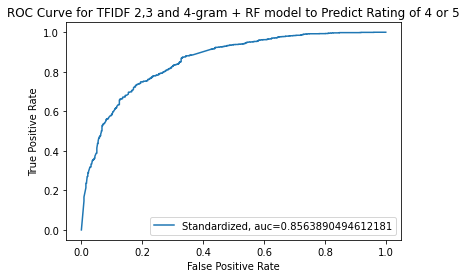

The TFIDF + 2,3,4-gram + RF model to Predict Rating of 4 or 5, AUROC is 0.8564


In [85]:
# Let's see how much lift the model gives.  The area under the curve is compared to 0.50.
y_pred = text_classifier2.predict(X_test)
from sklearn import metrics
y_pred_proba2 = text_classifier2.predict_proba(X_test)[::,1]    # Leave in this line, because it's the truer one.
# y_pred_proba2 = y_pred_proba[:,1]
fpr,tpr,_ = metrics.roc_curve(y_test, y_pred_proba2)

auc = metrics.roc_auc_score(y_test, y_pred_proba2)
#  auc2 = roc_auc_score(y_test, y_pred)

plt.plot(fpr,tpr,label="Standardized, auc="+str(auc))  
plt.title('ROC Curve for TFIDF 2,3 and 4-gram + RF model to Predict Rating of 4 or 5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

print("The TFIDF + 2,3,4-gram + RF model to Predict Rating of 4 or 5, AUROC is {:.4f}".format(auc))

array([0.21341095, 0.92069742, 0.99      , 0.97516967, 0.65845377,
       0.45923191, 0.93      , 0.83      , 0.89577108, 1.        ,
       0.86      , 0.36579535, 1.        , 0.91      , 0.96      ,
       0.92609239, 0.926875  , 1.        , 0.83220624, 0.49561485])

<Figure size 1440x864 with 0 Axes>

(0.0, 1.0)

C:\Users\lucin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

C:\Users\lucin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Random Forest Predicted vs Actual Rating of 4 or 5 \n Input variables are Tri-grams of words in Reviews')

Text(0, 0.5, 'Probability Density')

Text(0.5, 0, 'Probablility of 4 or 5 Rating based on Review words')

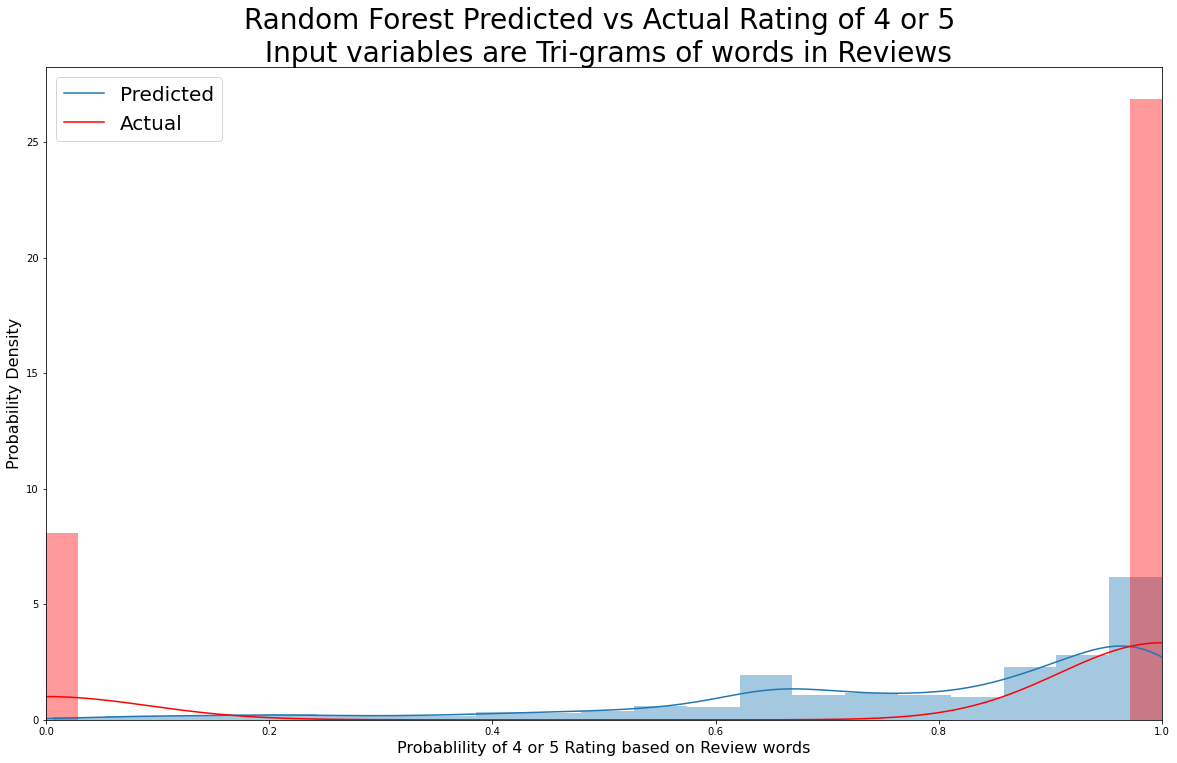

"# For numerical features only\nfeaturesNUM = list(data2.columns)\nfeaturesNUM.remove('y')\n"

stopped working        0.012732
waste money            0.012325
works great            0.011992
work star              0.009936
kill mosquitoes        0.004356
                         ...   
long mosquitos         0.000000
long need              0.000000
long need extension    0.000000
long product           0.000000
loaded bugs            0.000000
Length: 24575, dtype: float64

"\n# Horizontal Graph, but it's too crowded\n\nplt.figure(figsize=(38,20))\nsns.barplot(y=feature_imp, x=feature_imp.index)\n# Add labels to your graph\nplt.ylabel('Word Importance, by Decreasing Coefficient\n ', fontsize = 32)\nplt.xlabel('Words', fontsize = 32)\nplt.title('Most important N-grams, TFIDF + Random Forest Predicting Rating of 4 or 5 \n', fontsize = 36)\nplt.xticks(rotation = 35, horizontalalignment='right', fontsize = 20)\nplt.yticks(fontsize = 20)\nplt.legend()\nplt.show()"

In [86]:
# Look at Probability distribution of predicted values

y_pred_proba = text_classifier2.predict_proba(X_test)[::,1]
y_pred_proba[0:20]

# Raw distribution of counts is highly skewed 
plt.figure(figsize=(20,12))
plt.xlim(0,1)
sns.distplot(y_pred_proba)
sns.distplot(y_test, color='red', bins = 35)
plt.legend(['Predicted', 'Actual'], fontsize = 20)
plt.title('Random Forest Predicted vs Actual Rating of 4 or 5 \n Input variables are Tri-grams of words in Reviews', fontsize = 28)
plt.ylabel('Probability Density', fontsize=16)
plt.xlabel('Probablility of 4 or 5 Rating based on Review words', fontsize=16)
plt.show()

# Get Feature Importance, or the most important Tri-grams

# For categorical and numerical features
featuresNUM = list(df.columns)
featuresNUM.remove('target2')

'''# For numerical features only
featuresNUM = list(data2.columns)
featuresNUM.remove('y')
'''

import pandas as pd
feature_imp = pd.Series(text_classifier2.feature_importances_,featuresNUM).sort_values(ascending=False)
feature_imp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot with Top N features and coefficients
N = 200
feature_imp = feature_imp[:N,]

'''
# Horizontal Graph, but it's too crowded

plt.figure(figsize=(38,20))
sns.barplot(y=feature_imp, x=feature_imp.index)
# Add labels to your graph
plt.ylabel('Word Importance, by Decreasing Coefficient\n ', fontsize = 32)
plt.xlabel('Words', fontsize = 32)
plt.title('Most important N-grams, TFIDF + Random Forest Predicting Rating of 4 or 5 \n', fontsize = 36)
plt.xticks(rotation = 35, horizontalalignment='right', fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend()
plt.show()'''




<Figure size 1440x4320 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Word Importanc N-grams, TFIDF + RF, Predicting Review Ratings\n')

(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

Text(0, 0.5, 'Words')

Text(0.5, 0, 'Word Importance Coefficient')

No handles with labels found to put in legend.


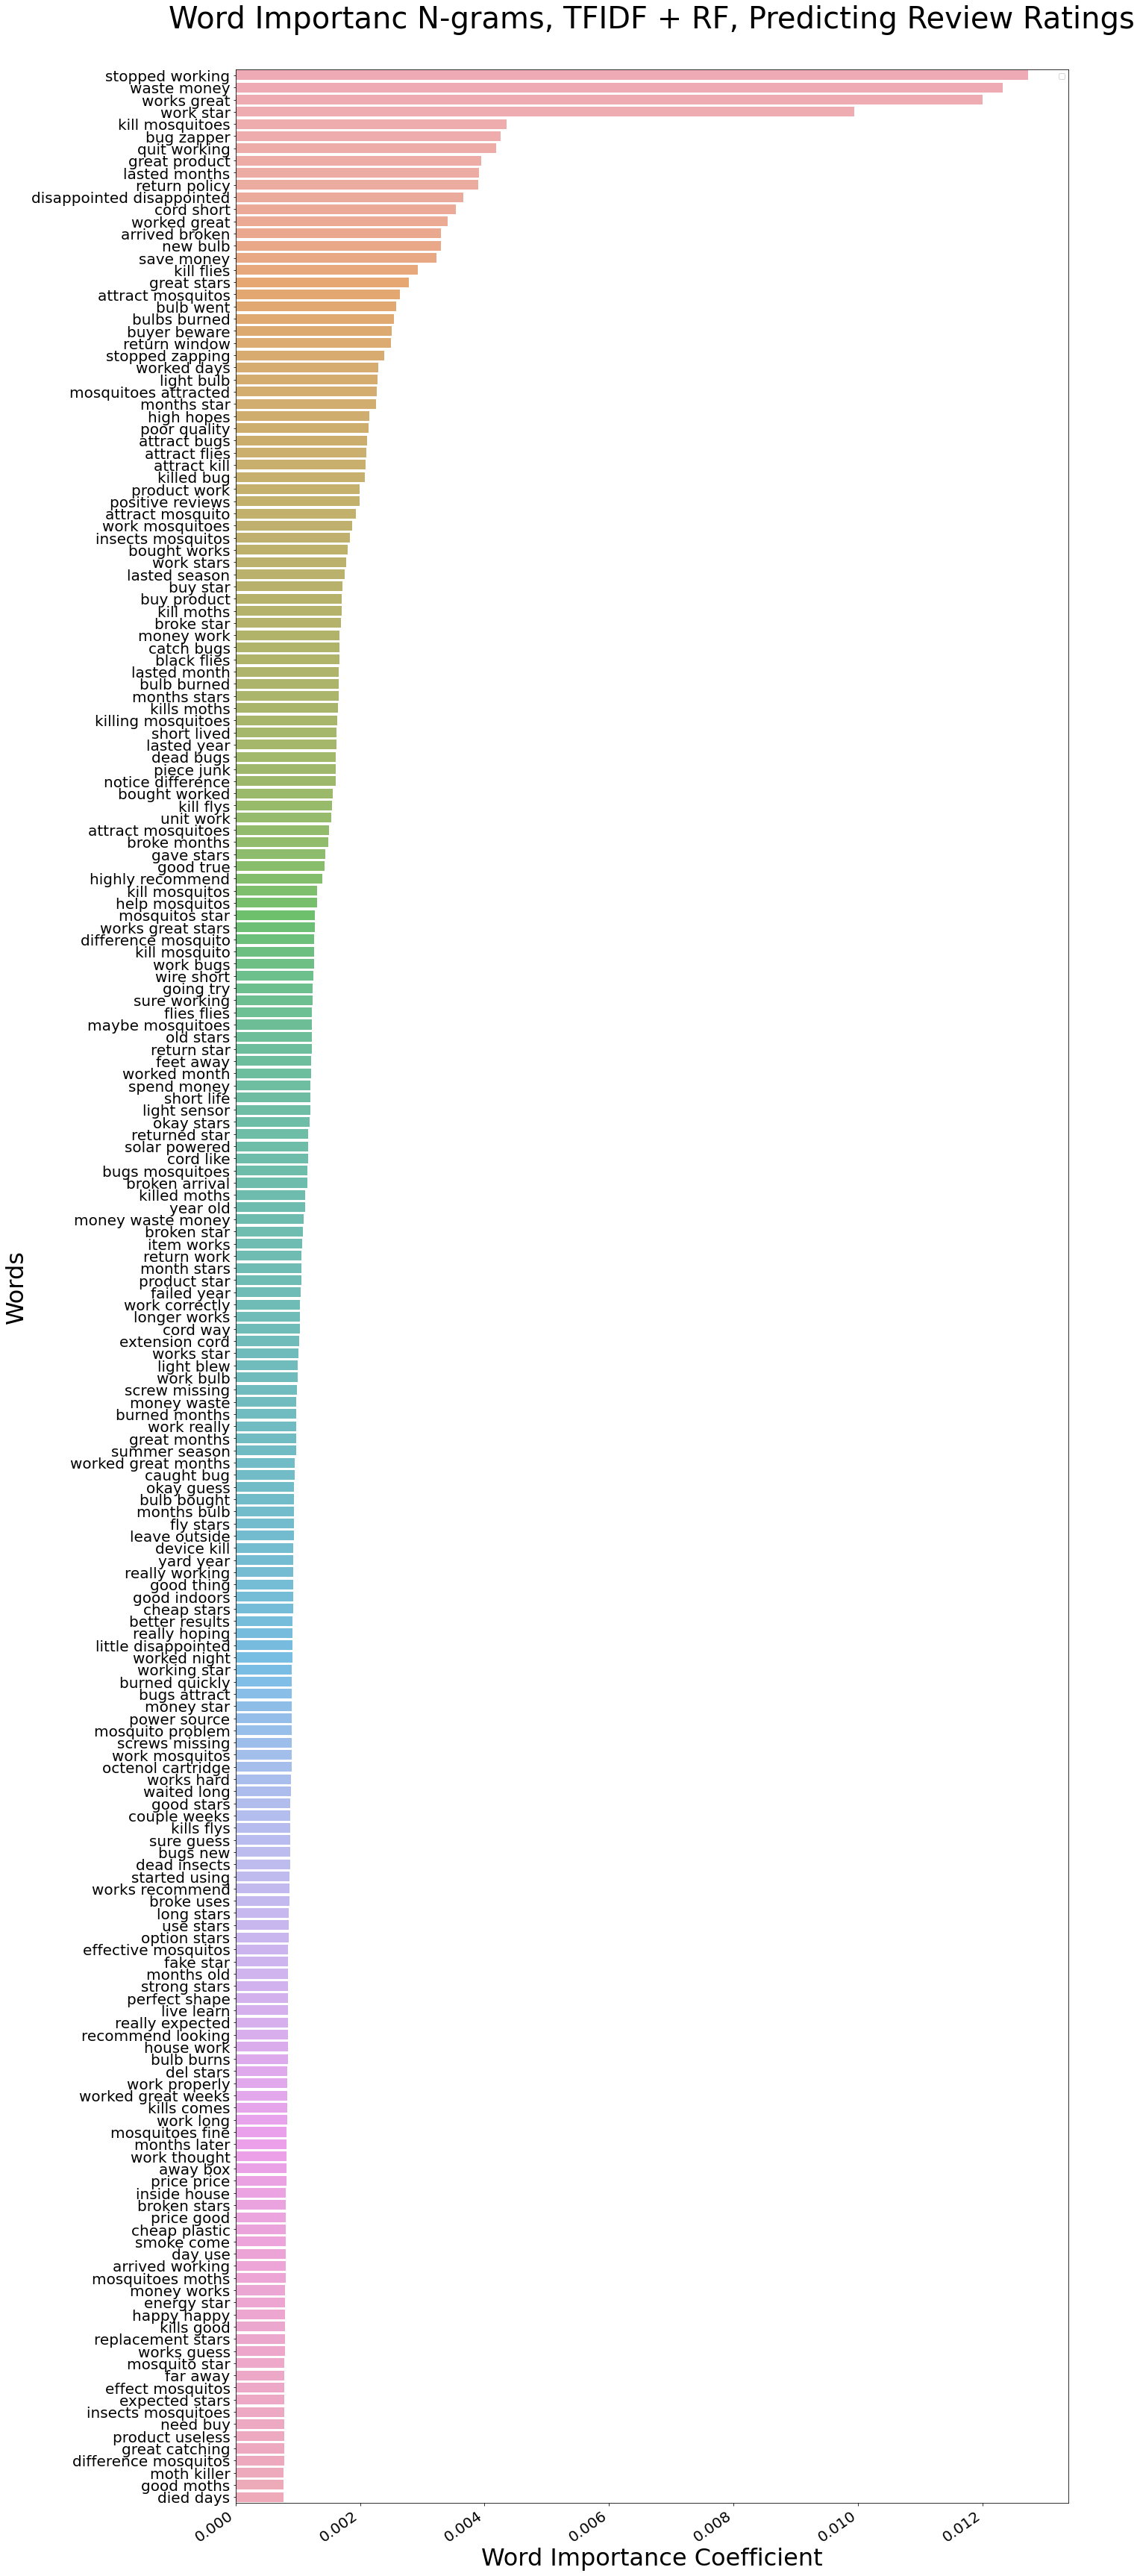

In [90]:
#  Plot 200 Most Important Features
#   Change to Vertical Plot

plt.figure(figsize=(20,60))
sns.barplot(x=feature_imp, y=feature_imp.index, alpha=0.8)
plt.title('Word Importanc N-grams, TFIDF + RF, Predicting Review Ratings\n', fontsize = 40)
plt.xticks(rotation = 35, horizontalalignment='right', fontsize  = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Words', fontsize=32)
plt.xlabel('Word Importance Coefficient', fontsize=32)
plt.legend()
plt.show()

### Try TFIDF to Vectorize and Logistic Regression to Predict

Results are similar to TFIDF + Random Forest with a threshold of 0.4. 
Note For TFIDF + Logistic Regression, threshold was changed so that any probability > 0.6 predicts a good review.

TFIDF + Logistic Regression Results:
* Accuracy is only 82%
* Recall on predicting Bad Reviews is 0.27

C:\Users\lucin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\lucin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,Unnamed: 0_x,category,tech1,description,fit,title,also_buy,tech2,brand,feature,...,rating,vote,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,unixReviewTime,image
0,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,2.0,7,False,"06 3, 2002",A1JYVOX5AX65N9,Julia,Poor product. It will kill insects after it is...,Flowtron Insect Killer,1023062400,NaN
1,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,5.0,20,False,"06 1, 2002",A2J2SZC2H8N0WZ,Ross,This bug popper really does a great job. You d...,Works Great!,1022889600,NaN
2,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,1.0,33,True,"04 27, 2002",ANIATM2KZ3OP7,Hugh D. Murray,It seemed to be doing the job. Then after less...,Already Broke!,1019865600,NaN
3,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,2.0,39,False,"10 9, 2001",A1T9WGRA28F339,Cecile,i would like to believe all the good reviews a...,not for tropical mosquitos,1002585600,NaN
4,425,"['Patio, Lawn & Garden', 'Pest Control', 'Bug ...",NaN,"[""Are you troubled by more insects than you ca...",NaN,Flowtron BK-80D 80-Watt Electronic Insect Kill...,"['B000063XHT', 'B00004R9VX', 'B00004R9W5', 'B0...",NaN,Flowtron,"['High efficiency, non-clogging killing grid, ...",...,5.0,242,True,"07 4, 2001",A3SJDVBBKUZILK,Amazon Customer,Here in Houston we have had a particularly dif...,Allows us to enjoy the outdoors again!!,994204800,NaN


Unnamed: 0_x          0
category              0
tech1              8166
description           0
fit                8166
title                 0
also_buy              0
tech2              8166
brand                 0
feature               0
rank                  0
also_view             0
main_cat              0
similar_item          0
date               8166
price                 0
asin                  0
imageURL              0
imageURLHighRes       0
details               0
Unnamed: 0_y          0
rating                0
vote               7291
verified              0
reviewTime            0
reviewerID            0
reviewerName          0
reviewText            0
summary               0
unixReviewTime        0
image              8050
dtype: int64

['rating', 'asin', 'reviewText', 'summary']

(8166, 4)

<ipython-input-65-ac493a8addc8>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_words'] = df['review_words'].str.replace("[^a-zA-Z+%0-9]", " ")


bugs        4030
works       3234
great       2889
one         2670
bug         2279
            ... 
altough        1
x12            1
atracted       1
alarmed        1
forming        1
Length: 10683, dtype: int64

dtm shape is:  (8166, 24575)
Here is part of the Trigram table
bow shape is:  (8166, 24575)


,000 mosquitoes,000 yard,100 acres,100 away,100 bug,100 bug free,100 bugs,100 failure,100 failure rate,100 feet,...,zika virus mosquito,zika works,zillions bugs,zip lock,zip sound,zip tie,zip ties,zip zap,zip zip,zip zip zap
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(8166, 24580)

,rating,asin,reviewText,summary,review_words,000 mosquitoes,000 yard,100 acres,100 away,100 bug,...,zika virus mosquito,zika works,zillions bugs,zip lock,zip sound,zip tie,zip ties,zip zap,zip zip,zip zip zap
0,2.0,B00004R9VV,Poor product. It will kill insects after it is...,Flowtron Insect Killer,poor product kill insects really dark outside ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,B00004R9VV,This bug popper really does a great job. You d...,Works Great!,bug popper really great job clean ever often r...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,B00004R9VV,It seemed to be doing the job. Then after less...,Already Broke!,seemed job less year quit working bought new b...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Sum of na's, by column:  rating          0
asin            0
reviewText      0
summary         0
review_words    0
               ..
zip tie         0
zip ties        0
zip zap         0
zip zip         0
zip zip zap     0
Length: 24580, dtype: int64
Sum of all na's in df:  0


(8166, 24580)

sum of target2 =  6252


0    poor product kill insects really dark outside ...
1    bug popper really great job clean ever often r...
2    seemed job less year quit working bought new b...
3    would like believe good reviews bk40d makes wo...
4    houston particularly difficult time mosquitos ...
Name: review_words, dtype: object

,rating,asin,reviewText,summary,review_words,000 mosquitoes,000 yard,100 acres,100 away,100 bug,...,zika works,zillions bugs,zip lock,zip sound,zip tie,zip ties,zip zap,zip zip,zip zip zap,target2
0,2.0,B00004R9VV,Poor product. It will kill insects after it is...,Flowtron Insect Killer,poor product kill insects really dark outside ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,5.0,B00004R9VV,This bug popper really does a great job. You d...,Works Great!,bug popper really great job clean ever often r...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.0,B00004R9VV,It seemed to be doing the job. Then after less...,Already Broke!,seemed job less year quit working bought new b...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


"X = df\nX = np.array(df.loc[row_indexer,col_indexer][:, df.columns != 'target2'])\ny = np.array(df.loc[row_indexer,col_indexer][:, df.columns == 'target2'])"

6252

'from sklearn.ensemble import RandomForestClassifier\ntext_classifier2 = RandomForestClassifier(n_estimators=100, random_state=0)  \ntext_classifier2.fit(X_train, y_train)\n'

C:\Users\lucin\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

[[ 126  347]
 [  14 1555]]
              precision    recall  f1-score   support

           0       0.90      0.27      0.41       473
           1       0.82      0.99      0.90      1569

    accuracy                           0.82      2042
   macro avg       0.86      0.63      0.65      2042
weighted avg       0.84      0.82      0.78      2042


Accuracy of N-grams + TFIDF + RFC model  model predicting Rating of Review is 0.8232


Text(0.5, 1.0, 'ROC Curve for TFIDF 2,3 and 4-gram + RF model to Predict Rating of 4 or 5')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

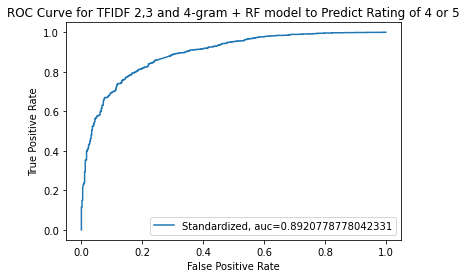

The TFIDF + 3-gram + RF model to Predict Rating of 4 or 5, AUROC is 0.8921


Text(0.5, 1.0, 'ROC Curve for TFIDF 2,3 and 4-gram + RF model to Predict Rating of 4 or 5')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

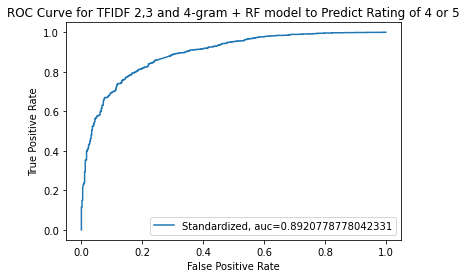

The TFIDF + 2,3,4-gram + RF model to Predict Rating of 4 or 5, AUROC is 0.8921


array([0.3185455 , 0.80479872, 0.91293707, 0.79469582, 0.7575985 ,
       0.70772423, 0.80603295, 0.71788942, 0.6987671 , 0.90256298,
       0.82749336, 0.69034011, 0.90525178, 0.87726643, 0.73314029,
       0.76760039, 0.83834328, 0.92403585, 0.83599085, 0.59163316])

<Figure size 1440x864 with 0 Axes>

(0.0, 1.0)

C:\Users\lucin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

C:\Users\lucin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'Random Forest Predicted vs Actual Rating of 4 or 5 \n Input variables are Tri-grams of words in Reviews')

Text(0, 0.5, 'Probability Density')

Text(0.5, 0, 'Probablility of 4 or 5 Rating based on Review words')

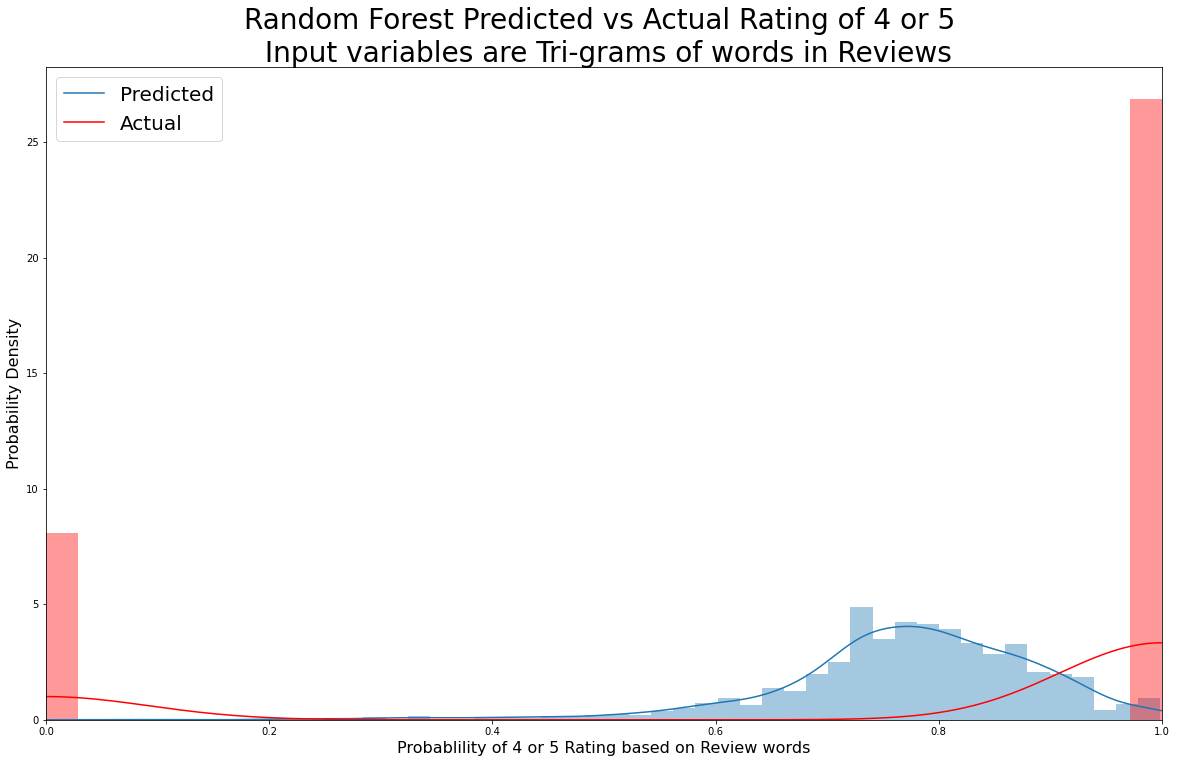

In [89]:
# Use the load_merge function to load the review and meta datasets, filter to one product, and merge the data for that product

# Take a subset of data, specifically one product   B00004R9VV  Flowtron Insect Killer
# For this product there should be 8166 rows and 31 columns in the Prod_merge output

Prod_merge = load_merge("Meta_Dataset.csv", "Reviews_Dataset.csv"   , 'B00004R9VV')    # OR  B00004R9VV
Prod_merge.head()

# Check for nulls in each column

df = Prod_merge
df.isnull().sum(axis = 0)


# Choose the features (column names) that we want to work with

# list(Prod_merge)
feat1 = ['rating',
 'asin',
 'reviewText',
 'summary']

feat1

# Create a df that includes the one hundred products with the most ratings = 1.  This will generate at dataset that has a 
# a variety of flaws that we can build recommendations upon.

Prod_merge = Prod_merge[feat1]
Prod_merge.shape
# Prod_merge.head(3)


# Define stop_words and use the pre-process function to pre-process the review_words in Prod_merge

stop_words = stopwords.words('english')
df = preprocess(Prod_merge, stop_words)

# NOTE !!!!!!    Do not do this twice or more- it repeats the concatenation.

# Let's count the most common terms in the 'name' column   ADAPTED FROM CAPSTONE AND MEL
df.review_words.str.split(expand=True).stack().value_counts()

# Make N-grams (Uni-gram, Bi-gram or Tri-gram)

# max_df - discard words that show up in x percent of documents has a scale 0 - 1
# min_df - is the opposite, minimum frequency can be a percent or raw number of documents
# ngram_range is normally (1,1) for single words, 2,2, for bi-grams, 3,3 for tri-grams

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english', ngram_range=(2,4))
# TF-IDF feature matrix
dtm = tfidf_vectorizer.fit_transform(df['review_words'])

# dtm

print("dtm shape is: ",dtm.shape)

# convert to dataframe for clustering
bow = pd.DataFrame(dtm.toarray(), columns = tfidf_vectorizer.get_feature_names())
print("Here is part of the Trigram table")
print("bow shape is: ", bow.shape)
bow

# To prevent concat creating many na's, reset the indices of both df and bow, so that they line up for the concat.
df.reset_index(drop=True, inplace=True)
bow.reset_index(drop=True, inplace=True)

# Now concatenate df and bow (bag of words-- in this case tri-grams -- that represent each review)
frames = [df, bow]
df3 = pd.concat(frames, axis = 1, ignore_index=False,)



df3.shape
df3.head(3)
print("Sum of na's, by column: ", df3.isnull().sum(axis = 0))
print("Sum of all na's in df: ", df3.isna().sum().sum())
df3.shape

# Create prediction categories of 
#     0 = Review of 1,2 or 3 stars 
#     1 = Review of 4 or 5 stars.  

# Make df = the df with n-grams (df3)
df = df3

# TO SET UP 2 CLASS PREDICTION TARGETS:
df['target2'] = 0

# Create a new column  called 'target2' where Rating is <= 3, then target2 is 0, otherwise the target2 = 1
# To Focus on BAD reviews (1,2,3 star)  use'target2' where Rating is <= 3, then target2 is 1, otherwise the target2 = 0
#              OR  df['target2'] = np.where(df['rating']<= 3, 1, 0)   HOWEVER all the results are the same- no difference.

df['target2'] = np.where(df['rating']<= 3, 0, 1)
print("sum of target2 = ",df.target2.sum())    # To verify that there aore 1096 reviews that are 4 or 5.


# df.dtypes
# df.head()
df.review_words.head()

df.head(3)

# list(df)  #See the column names, including the word combinations

# Set up df so it just contains the pre-processed words and the target

# print(list(df))
df = df.drop(['rating', 'asin', 'reviewText', 'summary',   'review_words'], axis=1)
# list(df)

'''X = df
X = np.array(df.loc[row_indexer,col_indexer][:, df.columns != 'target2'])
y = np.array(df.loc[row_indexer,col_indexer][:, df.columns == 'target2'])'''

X = df
X = np.array(df.loc[:, df.columns != 'target2'])
y = np.array(df.loc[:, df.columns == 'target2'])

# may need to use this  .loc[row_indexer,col_indexer]     instead of .loc

df.target2.sum()

# Random Forest model on n-grams

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


 
'''from sklearn.ensemble import RandomForestClassifier
text_classifier2 = RandomForestClassifier(n_estimators=100, random_state=0)  
text_classifier2.fit(X_train, y_train)
'''

# Try Logistic Regression with default settings
text_classifier2 = LogisticRegression()
text_classifier2.fit(X_train, y_train)

# Make it possible to change threshold for predicting 
threshold = 0.6

predicted_proba = text_classifier2.predict_proba(X_test)
y_pred = (predicted_proba [:,1] >= threshold).astype('int')
 
 
# y_pred = text_classifier2.predict(X_test)
 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))    # NOTE this means columns are predicted, rows are actual values

print()
print("Accuracy of N-grams + TFIDF + RFC model  model predicting Rating of Review is {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))


# Let's see how much lift the model gives.  The area under the curve is compared to 0.50.
y_pred = text_classifier2.predict(X_test)
from sklearn import metrics
y_pred_proba2 = text_classifier2.predict_proba(X_test)[::,1]    # Leave in this line, because it's the truer one.
# y_pred_proba2 = y_pred_proba[:,1]
fpr,tpr,_ = metrics.roc_curve(y_test, y_pred_proba2)

auc = metrics.roc_auc_score(y_test, y_pred_proba2)
#  auc2 = roc_auc_score(y_test, y_pred)

plt.plot(fpr,tpr,label="Standardized, auc="+str(auc))  
plt.title('ROC Curve for TFIDF 2,3 and 4-gram + RF model to Predict Rating of 4 or 5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

print("The TFIDF + 3-gram + RF model to Predict Rating of 4 or 5, AUROC is {:.4f}".format(auc))


# Let's see how much lift the model gives.  The area under the curve is compared to 0.50.
y_pred = text_classifier2.predict(X_test)
from sklearn import metrics
y_pred_proba2 = text_classifier2.predict_proba(X_test)[::,1]    # Leave in this line, because it's the truer one.
# y_pred_proba2 = y_pred_proba[:,1]
fpr,tpr,_ = metrics.roc_curve(y_test, y_pred_proba2)

auc = metrics.roc_auc_score(y_test, y_pred_proba2)
#  auc2 = roc_auc_score(y_test, y_pred)

plt.plot(fpr,tpr,label="Standardized, auc="+str(auc))  
plt.title('ROC Curve for TFIDF 2,3 and 4-gram + RF model to Predict Rating of 4 or 5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

print("The TFIDF + 2,3,4-gram + RF model to Predict Rating of 4 or 5, AUROC is {:.4f}".format(auc))




y_pred_proba = text_classifier2.predict_proba(X_test)[::,1]
y_pred_proba[0:20]

# Raw distribution of counts is highly skewed 
plt.figure(figsize=(20,12))
plt.xlim(0,1)
sns.distplot(y_pred_proba)
sns.distplot(y_test, color='red', bins = 35)
plt.legend(['Predicted', 'Actual'], fontsize = 20)
plt.title('Random Forest Predicted vs Actual Rating of 4 or 5 \n Input variables are Tri-grams of words in Reviews', fontsize = 28)
plt.ylabel('Probability Density', fontsize=16)
plt.xlabel('Probablility of 4 or 5 Rating based on Review words', fontsize=16)
plt.show()

